## Cryogenic Materials Repository Tutorial
Author: Henry Nachman

Created: 02 October 2025

Welcome to the Cryogenic Materials Repository - created by researchers at the University of Texas and supported by the CMB-S4 collaboration.

This notebook will walk you through the basics of using this repository using Python. By the end of this short tutorial you should be prepared to view the thermal conductivity fit of a material, and calculate and integrate the thermal conductivity using the fit.

First, let's start by resolving the necessary imports

### Using the Repository

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd

# Now we need to make sure that the parent folder is added to our path
# These paths may need to be adjusted on your machine

abspath = os.path.abspath("RepositoryTutorial.ipynb")
repo_path = os.path.dirname(os.path.dirname(abspath))
tc_path = os.path.join(repo_path, "thermal_conductivity")
lib_path = os.path.join(tc_path, "lib")

# It is important to add the path to the thermal conductivity folder
# to the system path that way we can use the modules we created
if tc_path not in sys.path:
    sys.path.insert(0, tc_path)

# Import the classes
from material_class import Material, Fit, DataSet
from fit_types import get_func_type
import pickle as pkl

Let's start by trying to load the material object for a material of interest

In [2]:
material_of_interest = "Aluminum"
path_to_mat = os.path.join(lib_path, material_of_interest)
if not os.path.exists(path_to_mat):
    raise FileNotFoundError(f"Material path {path_to_mat} does not exist")

mat_pickle_path = os.path.join(path_to_mat, f"material.pkl")
with open(mat_pickle_path, "rb") as f:
    mat_obj = pkl.load(f)

print(mat_obj)

Let's explore what is included in the material object

In [3]:
# Convert the material attributes dictionary to a pandas dataframe for easy viewing
mat_df = pd.DataFrame.from_dict(mat_obj.__dict__, orient='index', columns=['Value'])

mat_df

,Value
name,Aluminum
folder,lib\Aluminum
data_folder,lib\Aluminum\RAW
plot_folder,lib\Aluminum\PLOTS
parent,None
fit_type,loglog
fits,[<material_class.Fit object at 0x0000018A25D66...
data_classes,{'ALUMINUM1100_2008.csv': <material_class.Data...
temp_range,"(0.264, 1.061)"
raw_fit_params,"[66.519409407921, -21.422480979506656, 2.28426..."


Let's inspect the available fits in more detail

In [4]:
print([fit.name for fit in mat_obj.fits])

['Aluminum_1100_data', 'Aluminum_1100_NIST', 'Aluminum_3003F_NIST', 'Aluminum_5083O_NIST', 'Aluminum_6061T6_NIST', 'Aluminum_6061T6_Sauvage', 'Aluminum_6063T5_NIST', 'Aluminum_data', 'Aluminum_1100H14_data', 'Aluminum_1100O_data', 'Aluminum_6061T6_data']


This material has multiple fits. 

Let's pick one and explore it further.

In [5]:
my_mat_fit = mat_obj.fits[0]
mat_fit_df = pd.DataFrame.from_dict(my_mat_fit.__dict__, orient='index', columns=['Value'])
mat_fit_df

,Value
material,Aluminum_1100
source,data
name,Aluminum_1100_data
range,"(0.264, 1.061)"
parameters,"[-4.355148575377198, 9.862358478401868, 9.7799..."
parameter_covariance,"[[20895.16405508925, -20283.35168323681, 6504...."
fit_type,loglog
fit_error,None
reference,Data Fit (see references for included data)


From this dataframe, we can see that the fit we selected has the fit type `loglog`. Each fit object also has information on the `range`, `parameters`, and more.

The fit class also has some useful built in methods.

In [6]:
fit_methods = [method for method in dir(Fit) if callable(getattr(Fit, method)) and not method.startswith("__")]
print(fit_methods)

['add_reference', 'calc_tc', 'function', 'plot', 'tc_integral']


The material also has some useful methods.

In [7]:
mat_methods = [method for method in dir(Material) if callable(getattr(Material, method)) and not method.startswith("__")]
print(mat_methods)

['add_fits', 'fit_by_name', 'fit_data', 'get_data', 'get_fits', 'interpolate', 'plot_all_fits', 'plot_data', 'plot_data_fit', 'plot_interpolation', 'print_refs', 'save', 'save_fits', 'update_data', 'update_fit', 'update_material']


Let's try some of these out

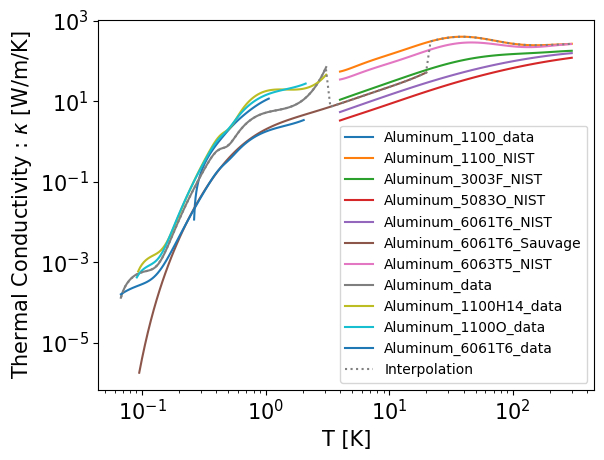

In [8]:
mat_obj.plot_all_fits()

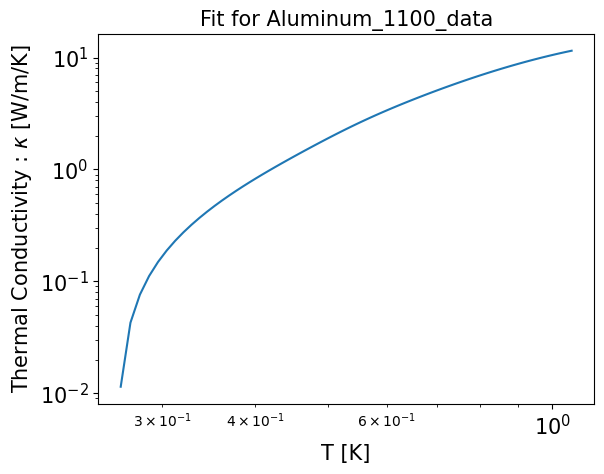

In [9]:
my_mat_fit.plot()

Let's try to calculate an integral with this fit.

In [10]:
# Let's see what the integral method looks like
print(help(my_mat_fit.tc_integral))
# It looks like we will need some astropy units
from astropy import units as u
# Define the temperature range for the integral
T_min = 500*u.mK  # Minimum temperature in Kelvin
T_max = 800*u.mK  # Maximum temperature in Kelvin

integral_value = my_mat_fit.tc_integral(T_min, T_max)
print(f"Integral of thermal conductivity from {T_min} to {T_max} is {integral_value[0]:.2f}")

Help on method tc_integral in module material_class:

tc_integral(T1: Unit("K"), T2: Unit("K")) method of material_class.Fit instance
    Calculate the integral of the thermal conductivity over a temperature range.
    Args:
        T1 (u.K): Lower temperature limit.
        T2 (u.K): Upper temperature limit.
    Returns:
        integral (u.W/m): The integral of thermal conductivity from T1 to T2.
        error (float): Estimated error of the integral.

    Uses astropy units to ensure correct unit handling.

None
Integral of thermal conductivity from 500.0 mK to 800.0 mK is 1.28 W / m


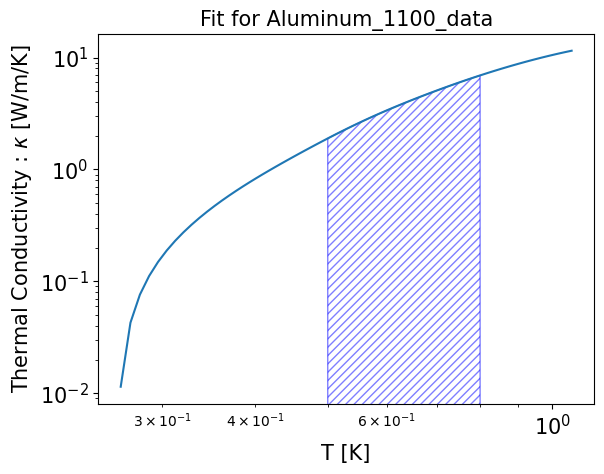

In [11]:
my_mat_fit.plot()
# Let's make our plotting range the listed fit range
fill_between_range = np.linspace(T_min.to(u.K).value, T_max.to(u.K).value, 1000)

# To get the function of the fit we can use the function method
# my_mat_fit.function()
# This returns a callable function that takes in the temperature array
y_vals = my_mat_fit.function()(fill_between_range, *my_mat_fit.parameters)
plt.fill_between(fill_between_range, np.zeros(len(fill_between_range)), y_vals,
                 hatch="////", alpha = 0.5, edgecolor = 'b', facecolor="w",
                 label="Integration Area")

### Adding A New Material

Adding materials and data is a crucial functionality of the repository to keep it able to respond to future measurements. The following code can be used to update the repository after adding a new material or dataset.

In [12]:
# For this example I am going to pretend I have a new TESTMAT material in which I have added a dataset to the RAW folder
from tc_utils import get_material

material_to_update = "TESTMAT"
# Open the pickle file
os.chdir(os.path.join(tc_path))
test_mat = Material(material_to_update, force_update=True) #get_material(material_to_update)
test_mat.save()
print(test_mat.fits)


Material has successfully been saved to its pickle file!


### Adding a New Dataset

Go ahead and copy a new data csv to the raw folder

To update the material in the repository with the new dataset we will use the `update_material` function

In [13]:
help(test_mat.update_material)

Help on method update_material in module material_class:

update_material() method of material_class.Material instance
    Update the material after adding a dataset



In [14]:
# Let's see what data is already in the TESTMAT material
test_mat = get_material(material_to_update)
print(test_mat.data_classes)
# Already included is one dataset
# But if we print the number of files in the RAW folder
print([filename for filename in os.listdir(os.path.join(tc_path,test_mat.data_folder))])
# We see that there are indeed 2 files (not just 1 dataset)

{'test_raw.csv': <material_class.DataSet object at 0x0000018A26C84D10>, 'test_raw_2.csv': <material_class.DataSet object at 0x0000018A26C879B0>}
['test_raw.csv', 'test_raw_2.csv']


In [15]:
# To get the material to recognize the new dataset we can use
# First we need to change our working directory so that the data folder is recognized
# (This is because the folder path is relative to ensure smooth operation on all devices)
os.chdir(os.path.join(tc_path))
# brass.fit_data()
test_mat.update_material()

Updating existing data fit.
Material has successfully been saved to its pickle file!


### Adding a New Fit

In [16]:
# Load the material object
test_mat = get_material(material_to_update)

# Let's see what fits already exist
print(test_mat.fits)

Start by creating a Fit object of the new fit

In [17]:
new_fit = Fit(
    material = test_mat.name,
    source = "tutorial_example",
    range = (0.1, 10.0), # Range in Kelvin
    parameters = [20e-6, 2], # Example parameters
    parameter_covariance = [0, 0], # Error in the parameters (if known)
    fit_type = "powerlaw",
    reference = "HN Tutorial Example"
)

Now we will simply append this new fit to the list of fits for the material.

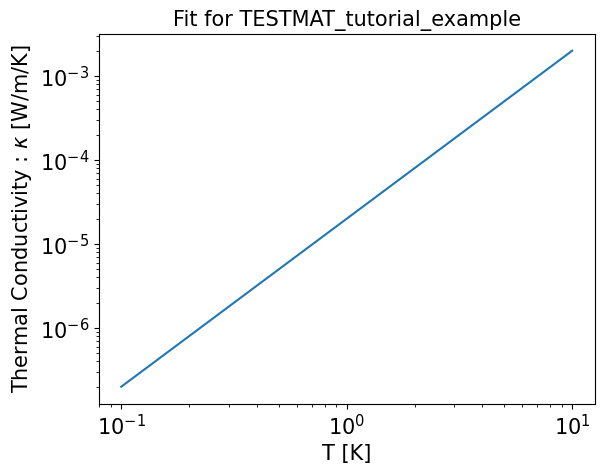

In [ ]:
test_mat.fits.append(new_fit)
test_mat.save()
new_fit.plot()

### Updating the Repository

Run the `update_repo.py` file or the following cell

In [19]:
from update_repo import main as update_repository

update_repository(mat_list = None) # mat_list = None will update all materials, or you can provide a list of material names to update specific ones

Updating materials:  19%|>         | 17.0/90.0 [00:21<01:37, 1.33s/mat]

Error updating material Cu_OFHC: 'float' object is not subscriptable


Updating materials: 101mat [01:37, 1.03mat/s]                          .61mat/s]


Material README.md has no fits, skipping compilation file creation.
